Faces classification (drawn from sklearn example)
=====================================================
MWEM is not particularly well suited for image data (where there are tons of features with relatively large ranges) but it is still able to capture some important information about the underlying distributions if tuned correctly.

We use a feature included with MWEM that allows a column to be specified for a custom bin count, if we are capping every other bin count at a small value. In this case, we specify that the numerical column (784) has 10 possible values. We do this with the dict {'784': 10}.

Here we borrow from a scikit-learn example, and insert MWEM synthetic data into their training example/visualization, to understand the tradeoffs.

https://scikit-learn.org/stable/auto_examples/linear_model/plot_sparse_logistic_regression_mnist.html#sphx-glr-download-auto-examples-linear-model-plot-sparse-logistic-regression-mnist-py


In [1]:
import warnings
warnings.filterwarnings('ignore')
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
from snsynth.gsd import GSDSynthesizer

# pip install scikit-image
# from skimage import data, color
# from skimage.transform import rescale

# Author: Arthur Mensch <arthur.mensch@m4x.org>
# License: BSD 3 clause

from time import time

from scipy.stats import loguniform
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [2]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [39]:
n_components = 250

print(
    "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0])
)
t0 = time()
pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

X_rec = pca.inverse_transform(X_test_pca)
print("done in %0.3fs" % (time() - t0))

Extracting the top 250 eigenfaces from 966 faces
done in 0.495s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.023s


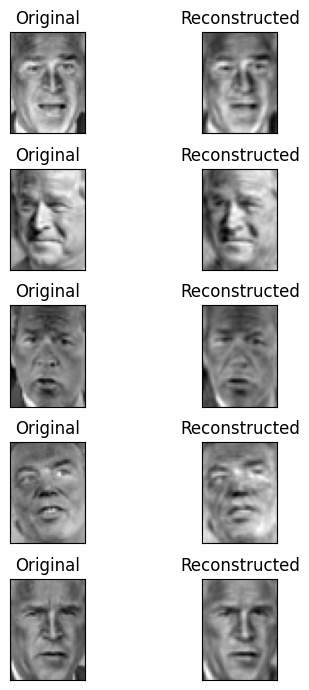

In [41]:
def plot_gallery(images, rec_images, h, w, n_row=3, n_col=4, start=0):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * 2, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    rows = 5



    for i in range(rows):
        plt.subplot(rows, 2, 2*i + 1)
        plt.imshow(images[start+i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title('Original', size=12)
        plt.xticks(())
        plt.yticks(())

        plt.subplot(rows, 2, 2*i + 2)
        plt.imshow(rec_images[start+i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title('Reconstructed', size=12)
        plt.xticks(())
        plt.yticks(())


def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(" ", 1)[-1]
    true_name = target_names[y_test[i]].rsplit(" ", 1)[-1]
    return "predicted: %s\ntrue:      %s" % (pred_name, true_name)


plot_gallery(X_test, X_rec, h, w, start=10)

In [42]:
columns = []
for i in range(n_components):
    columns.append(f'c_{i:03d}')
columns.append('Label')
data_df = pd.DataFrame(np.column_stack((X_train_pca, y_train)), columns=columns)


In [43]:
marginals = []
for i in range(n_components):
    marginals.append((f'c_{i:03d}', 'Label'))


In [44]:
from snsynth.transform import TableTransformer, BinTransformer, LabelTransformer, MinMaxTransformer

transformers = []
for i in range(n_components):
    c = f'c_{i:03d}'
    mx = data_df[c].max()
    mn = data_df[c].min()
    transformers.append(MinMaxTransformer(lower=mn, upper=mx, negative=False))
transformers.append(LabelTransformer())
transformer = TableTransformer(transformers)


In [51]:
synth = GSDSynthesizer(epsilon=1000.0 , delta=1e-5, tree_height=8, verbose=True)
synth.fit(data_df,
          transformer=transformer,
          marginals=marginals,
          early_stop_threshold=0.00003)


Marginal= ('c_000', 'Label') . Sigma=0.0023. Top.Level=8. Max.Size=None
Marginal= ('c_001', 'Label') . Sigma=0.0023. Top.Level=8. Max.Size=None
Marginal= ('c_002', 'Label') . Sigma=0.0023. Top.Level=8. Max.Size=None
Marginal= ('c_003', 'Label') . Sigma=0.0023. Top.Level=8. Max.Size=None
Marginal= ('c_004', 'Label') . Sigma=0.0023. Top.Level=8. Max.Size=None
Marginal= ('c_005', 'Label') . Sigma=0.0023. Top.Level=8. Max.Size=None
Marginal= ('c_006', 'Label') . Sigma=0.0023. Top.Level=8. Max.Size=None
Marginal= ('c_007', 'Label') . Sigma=0.0023. Top.Level=8. Max.Size=None
Marginal= ('c_008', 'Label') . Sigma=0.0023. Top.Level=8. Max.Size=None
Marginal= ('c_009', 'Label') . Sigma=0.0023. Top.Level=8. Max.Size=None
Marginal= ('c_010', 'Label') . Sigma=0.0023. Top.Level=8. Max.Size=None
Marginal= ('c_011', 'Label') . Sigma=0.0023. Top.Level=8. Max.Size=None
Marginal= ('c_012', 'Label') . Sigma=0.0023. Top.Level=8. Max.Size=None
Marginal= ('c_013', 'Label') . Sigma=0.0023. Top.Level=8. Max.Si

Bush
Bush
Bush
Bush
Bush
Bush
Bush
Bush
Bush
Bush
Bush
Bush
Bush
Bush
Bush
Bush
Bush
Bush
Bush
Bush


<Figure size 180x240 with 0 Axes>

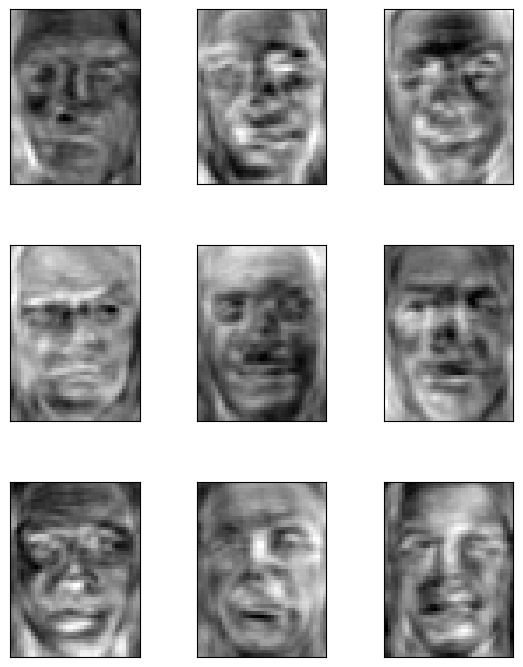

<Figure size 180x240 with 0 Axes>

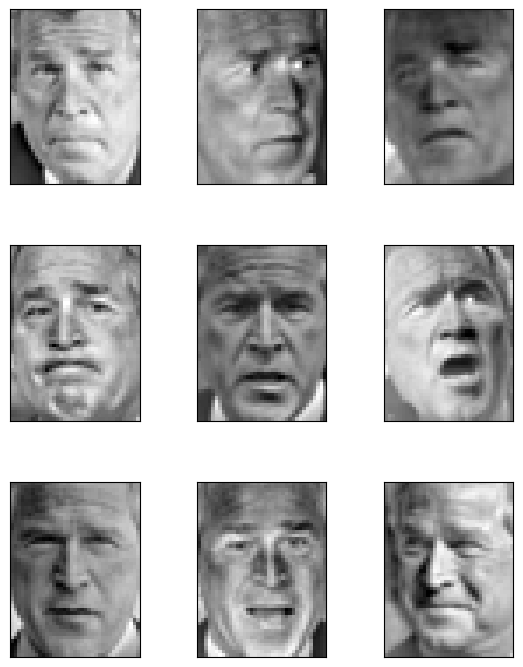

In [50]:

def plot_class(images, y, target, h, w, n_col=3, n_row=3):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8, 2.4 ))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    cnt = 0
    # for i in range(n_row * n_col):
    for i in range(images.shape[0]):
        class_name = target_names[int(y[i])].rsplit(" ", 1)[-1]
        if class_name == target:
            print(class_name)
            cnt = cnt + 1
            if cnt > n_row * n_col: break
            plt.subplot(n_row, n_col, cnt)
            plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
            # plt.title(titles[i], size=12)
            plt.xticks(())
            plt.yticks(())

sync_pca = synth.sample().values
X_sync_pca = sync_pca[:, :-1]
y_sync =  sync_pca[:, -1]
X_sync = pca.inverse_transform(X_sync_pca)
plot_class(X_sync, y_sync, 'Bush', h, w)
plot_class(X_test, y_test, 'Bush', h, w)



In [ ]:
model = RidgeClassifier
synth_df = pd.DataFrame(synthetic, 
    columns=real.columns)

X = real.iloc[:, :-1]
y = real.iloc[:, -1]
X_synth = synth_df.iloc[:, :-1]
y_synth = synth_df.iloc[:, -1]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
x_train_synth, x_test_synth, y_train_synth, y_test_synth = train_test_split(X_synth, y_synth, test_size=0.2, random_state=42)

print(y_train)
print(y_train_synth)

model_real = model()
model_real.fit(x_train, y_train)

print(y_train_synth.max())
print(y_train_synth.min())

# model_fake = model()
# model_fake.fit(x_train_synth, y_train_synth)



In [ ]:
from sklearn.linear_model import RidgeClassifier

import utils

real = pd.DataFrame(data_np[:sample_size])

model_real, model_fake = utils.test_real_vs_synthetic_data(real, synthetic, RidgeClassifier, tsne=True)

In [ ]:
# Classification 
coef = model_real.coef_.copy()
plt.figure(figsize=(10, 5))
scale = np.abs(coef).max()
for i in range(10):
    l1_plot = plt.subplot(2, 5, i + 1)
    l1_plot.imshow(coef[i].reshape(28, 28), interpolation='nearest',
                   cmap=plt.cm.RdBu, vmin=-scale, vmax=scale)
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel('Class %i' % i)
plt.suptitle('Classification vector for...')

run_time = time.time() - t0
print('Example run in %.3f s' % run_time)
plt.show()

In [ ]:
coef = model_fake.coef_.copy()
plt.figure(figsize=(10, 5))
scale = np.abs(coef).max()
for i in range(10):
    l1_plot = plt.subplot(2, 5, i + 1)
    l1_plot.imshow(coef[i].reshape(28, 28), interpolation='nearest',
                   cmap=plt.cm.RdBu, vmin=-scale, vmax=scale)
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel('Class %i' % i)
plt.suptitle('Classification vector for...')

run_time = time.time() - t0
print('Example run in %.3f s' % run_time)
plt.show()